In [1]:
# Import the necessary libraries and modules

# Load and manipulate data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Deep learning framework
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

# Image processing
from PIL import Image

# Progress bar
from tqdm.auto import tqdm

# Model visualization
from torchinfo import summary


In [2]:
# Set the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define the MelCepstrum dataset class
class MelCepstrum(Dataset):
    def __init__(self,  file, transform=None):
        self.datas = pd.read_csv(file) # Read the CSV file
        self.transform = transform # Transformations to be applied to each sample

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, index):
        path = 'music_train/' + self.datas.iloc[index, 0] # Get the file path of the image
        image = Image.open(path).convert('RGB')  # Open the image and convert it to RGB format
        label = torch.tensor(int(self.datas.iloc[index, 1])) # Get the label of the image and convert it to a tensor

        if self.transform:
            image = self.transform(image) # Apply the specified transformation to the image

        return image, label


In [4]:
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0002
NUM_CLASSES = 88


In [5]:
# Define the transformation for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image
    transforms.ToTensor(), # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Normalize the image tensor

In [6]:
dataset = MelCepstrum(file='train_truth.csv', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
# Determine the sizes of the training and validation sets (0.7 for training, 0.3 for validation)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # Use the random_split to split the dataset


In [7]:
# Create data loader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [8]:
# Define the CNN_Model
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the convolutional layers
        self.model = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2),
                                   )
        # Define the fully connected layers
        self.fc_layers = nn.Sequential(nn.Linear(256 * 56 * 56, 128),
                                       nn.ReLU(),
                                       nn.Linear(128, 64),
                                       nn.ReLU(),
                                       nn.Linear(64, NUM_CLASSES)
                                       )

    def forward(self, x):
        x = self.model(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [9]:
def train_epoch(model, dataloader, loss_fn, optimizer, device) -> float:
    size = len(dataloader.dataset) # Total number of samples in the dataset
    num_batches = len(dataloader)  # Number of batches per epoch
    train_loss, train_correct = 0.0, 0.0
    model.train()  # Set model to training mode
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        output = model(x)  # Forward propagation
        loss = loss_fn(output, y)  # Calculate loss
        train_loss += loss.item()  # Accumulate loss
        optimizer.zero_grad()  # Zero gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_correct += (output.argmax(1) == y).type(torch.float).sum().item() # Compute the number of correct predictions

    return train_loss/num_batches, 100*train_correct/size  # Return average loss

In [10]:
def valid_epoch(model, dataloader, loss_fn, device) -> float:
    size = len(dataloader.dataset) # Total number of samples in the dataset
    num_batches = len(dataloader)  # Number of batches per epoch
    valid_loss, valid_correct = 0.0, 0.0
    model.eval()  # Set model to evaluation mode
    with torch.inference_mode(mode=True):
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            output = model(x)  # Get model prediction
            loss = loss_fn(output, y)  # Calculate loss
            valid_loss += loss.item()  # Accumulate loss
            valid_correct += (output.argmax(1) == y).type(torch.float).sum().item() # Compute the number of correct predictions
    return valid_loss/num_batches, 100*valid_correct/size  # Return average loss

In [11]:
def train(model, train_loader, valid_loader, loss_fn, optimizer, epochs, device):
    # Initializes a defaultdict to store the training and validation losses at each epoch
    result = defaultdict(list)
    # Moved the model to the specified device
    model.to(device)
    # Iterates through each epoch
    for epoch in tqdm(range(1, epochs + 1)):
        # Train the model and calculate the training loss
        train_loss, train_acc = train_epoch(
            model, train_loader, loss_fn, optimizer, device)
        # Calculate the validation loss
        valid_loss, valid_acc = valid_epoch(model, valid_loader, loss_fn, device)
        # Appended the training and validation losses to the result
        result['train_loss'].append(train_loss)
        result['train_accuracy'].append(train_acc)
        result['valid_loss'].append(valid_loss)
        result['valid_accuracy'].append(valid_acc)
        print(f"Epoch: {epoch} Train accuracy: {train_acc} Train loss: {train_loss} Valid accuracy: {valid_acc} Valid loss: {valid_loss}")
    return result  # Return the training and validation losses at each epoch


In [12]:
model = CNN_Model()
loss_fn = nn.CrossEntropyLoss() # Define the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # Define the optimizer

In [13]:
# Perform the training and validation
result = train(model, train_loader, val_loader, loss_fn, optimizer, EPOCHS, device)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 Train accuracy: 5.170682730923695 Train loss: 4.2231538030836315 Valid accuracy: 22.014051522248245 Valid loss: 3.1631242080971047
Epoch: 2 Train accuracy: 71.93775100401606 Train loss: 1.1561117951004278 Valid accuracy: 98.24355971896955 Valid loss: 0.13329288239280382
Epoch: 3 Train accuracy: 99.74899598393574 Train loss: 0.026382233389461086 Valid accuracy: 99.76580796252928 Valid loss: 0.008187684631492529
Epoch: 4 Train accuracy: 100.0 Train loss: 0.001424559557822899 Valid accuracy: 99.76580796252928 Valid loss: 0.00364227470601219
Epoch: 5 Train accuracy: 100.0 Train loss: 0.0005811852904679697 Valid accuracy: 99.76580796252928 Valid loss: 0.003292752173837033
Epoch: 6 Train accuracy: 100.0 Train loss: 0.0004048740822962293 Valid accuracy: 99.76580796252928 Valid loss: 0.0030359955406445943
Epoch: 7 Train accuracy: 100.0 Train loss: 0.0003121575268561996 Valid accuracy: 99.76580796252928 Valid loss: 0.0028527510881691275
Epoch: 8 Train accuracy: 100.0 Train loss: 0.0002

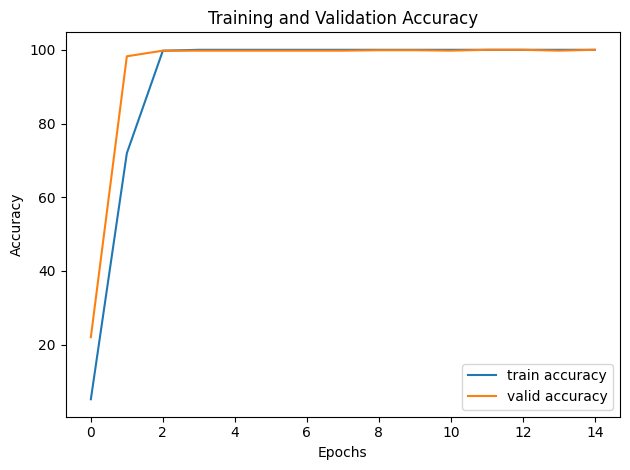

In [14]:
# Plot the Accuracy history

# Get the number of epochs
epochs = range(len(result['train_loss']))

# Create a new figure for the plot
plt.figure()
# Set the title of the plot
plt.title('Training and Validation Accuracy')
# Set the label for the x-axis
plt.xlabel('Epochs')
# Set the label for the y-axis
plt.ylabel('Accuracy')
# Plot the training loss over epochs
plt.plot(epochs, result['train_accuracy'], label='train accuracy')
# Plot the validation loss over epochs
plt.plot(epochs, result['valid_accuracy'], label='valid accuracy')
# Add a legend to the plot
plt.legend()
plt.tight_layout()
# Save the plot
plt.savefig('Training and Validation Accuracy.png')
# Display the plot
plt.show()


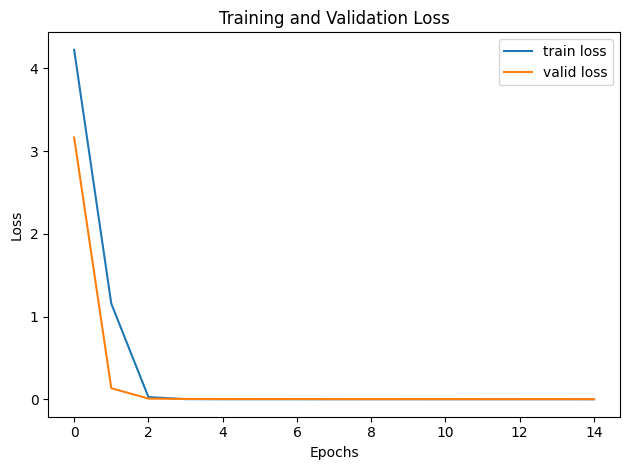

In [15]:
# Plot the Loss history

# Create a new figure for the plot
plt.figure()
# Set the title of the plot
plt.title('Training and Validation Loss')
# Set the label for the x-axis
plt.xlabel('Epochs')
# Set the label for the y-axis
plt.ylabel('Loss')
# Plot the training loss over epochs
plt.plot(epochs, result['train_loss'], label='train loss')
# Plot the validation loss over epochs
plt.plot(epochs, result['valid_loss'], label='valid loss')
# Add a legend to the plot
plt.legend()
plt.tight_layout()
# Save the plot
plt.savefig('Training and Validation Loss.png')
# Display the plot
plt.show()


In [16]:
test_imgs = os.listdir('music_test') # Get the list of test image files
model.eval() # Set the model to evaluation mode
outputs = [] # Create an empty list to store the outputs

# Iterate over each image file in the test directory
for img_file in test_imgs:
    path = os.path.join('music_test', img_file) # Get the path of the image file
    img = Image.open(path).convert('RGB') # Open and convert the image to RGB
    test_img = transform(img).unsqueeze(0).to(device) # Apply the transformation to the image and convert it to a tensor
    output = model(test_img) # Pass the image through the model to get the output
    _, predicted = torch.max(output.data, 1) # Get the predicted class label
    predicted = predicted.cpu().numpy().tolist() # Convert the predicted label to a numpy array and extract the first element
    outputs.append([img_file[:],predicted[0]]) # Append the image filename and predicted label

submission = pd.DataFrame(outputs, columns=['filename', 'category']) # Create a DataFrame from the outputs
submission.to_csv('submission.csv', index=False) # Save the CSV file

In [17]:
# Print the model summary
summary(model, input_size=(32, 3, 224, 224))

c:\Users\River\anaconda3\envs\pytorch\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\River\anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
CNN_Model                                [32, 88]                  --
├─Sequential: 1-1                        [32, 256, 56, 56]         --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 128, 224, 224]       73,856
│    └─ReLU: 2-4                         [32, 128, 224, 224]       --
│    └─MaxPool2d: 2-5                    [32, 128, 112, 112]       --
│    └─Conv2d: 2-6                       [32, 256, 112, 112]       295,168
│    └─ReLU: 2-7                         [32, 256, 112, 112]       --
│    └─MaxPool2d: 2-8                    [32, 256, 56, 56]         --
├─Sequential: 1-2                        [32, 88]                  --
│    └─Linear: 2-9                       [32, 128]                 102,760,576
│    └─ReLU: 2-10                        [32, 128]              


(dot.exe:7944): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:7704): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


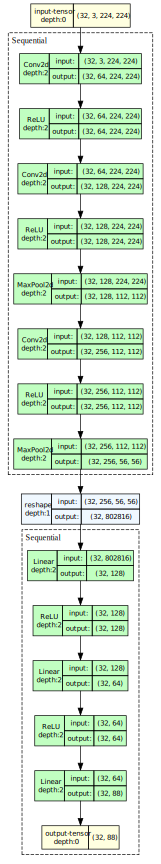

In [18]:
from torchview import draw_graph

graph = draw_graph(model, input_size=(32, 3, 224, 224), expand_nested=True, save_graph=True, filename='CNN_Model')
graph.visual_graph